<a href="https://colab.research.google.com/github/VinayNooji/FourthBrain/blob/main/ML_for_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This assignment is designed for automated pathology detection for Medical Images in a relalistic setup, i.e. each image may have multiple pathologies/disorders. 
### The goal, for you as an MLE, is to design models and methods to predictively detect pathological images and explain the pathology sites in the image data.

## Data for this assignment is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview
Explanation of the data set:
The training data set contains 3435 retinal images that represent multiple pathological disorders. The patholgy classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
The test data set contains 350 unlabelled images.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May  8 07:04:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/FourthBrain/Week8-Midterm'
#!unzip Data.zip

/content/drive/MyDrive/FourthBrain/Week8-Midterm


In [5]:
%load_ext tensorboard
from tensorflow import keras
import os


In [6]:
# multi-class classification with Keras
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
# load dataset
from keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
from tqdm import tqdm

PATH='./Data/train/train/'
input_csv_data = pd.read_csv("./Data/train/train.csv")
print(list(input_csv_data.columns))

['filename', 'opacity', 'diabetic retinopathy', 'glaucoma', 'macular edema', 'macular degeneration', 'retinal vascular occlusion', 'normal']


In [8]:
normal_label = input_csv_data.index[input_csv_data['normal'] == 1].to_numpy()
#drg_label_tgr = input_csv_data.index[(input_csv_data['diabetic retinopathy'] == 1) | (input_csv_data['glaucoma'] == 1)].to_numpy()
#drg_label_ex = input_csv_data.index[(input_csv_data['diabetic retinopathy'] == 1) & (input_csv_data['glaucoma'] == 1)].to_numpy()
diag_retino_label = input_csv_data.index[(input_csv_data['diabetic retinopathy'] == 1)].to_numpy()
glaucoma_label = input_csv_data.index[(input_csv_data['glaucoma'] == 1)].to_numpy()
arr1 = np.concatenate((diag_retino_label, glaucoma_label))
arr2 = np.concatenate((arr1, normal_label))
#print(arr2[:25])
image_labels = input_csv_data.loc[arr2,['filename']].to_numpy()
data_labels = input_csv_data.loc[arr2, ['diabetic retinopathy', 'glaucoma', 'normal']].to_numpy()
print(f'{PATH+image_labels[25][0]}')

./Data/train/train/ce4ef8ff79e4.jpg


In [36]:
from keras.preprocessing import image

train_image = []
for i in tqdm(range(image_labels.shape[0])):
    img = image.load_img(PATH+image_labels[i][0], target_size=(256,256,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 1877/1877 [00:12<00:00, 152.34it/s]


In [10]:
target_names = ['diabetic retinopathy', 'glaucoma', 'normal']
print(target_names)

['diabetic retinopathy', 'glaucoma', 'normal']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, data_labels, random_state=42, test_size=0.3)
print(f'X_train shape {X_train.shape}, X_test shape {X_test.shape}, y_train shape {y_train.shape}, y_test shape {y_test.shape}')


X_train shape (1313, 256, 256, 3), X_test shape (564, 256, 256, 3), y_train shape (1313, 3), y_test shape (564, 3)


In [12]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import History
def Plot_History(history):
  print(history.history)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'bo', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'ro', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759

Followed the instruction to plot Heatmap.

In [13]:
import cv2
from google.colab.patches import cv2_imshow
import tensorflow.keras.backend as K

def gradCAM(orig, model, layer_info, shape = 6, intensity=0.5, res=250):
  img = image.load_img(orig, target_size=(256,256,1), grayscale=False)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  #print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer(layer_info)
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((shape, shape))

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))
  cv2_imshow(cv2.resize(img, (res, res)))

Tried both Multi-label and Multi-class classification. Multi-class classification produced better accuracy.

https://towardsdatascience.com/multi-label-image-classification-with-neural-network-keras-ddc1ab1afede

https://analyticsindiamag.com/multi-label-image-classification-with-tensorflow-keras/

https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24

https://github.com/suraj-deshmukh/Keras-Multi-Label-Image-Classification/

https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96

https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1

https://morioh.com/p/fa76d93bfca8

https://keras.io/api/applications/



87916544/87910968 [==============================] - 1s 0us/step
314
Epoch 1/8
42/42 [==============================] - 27s 126ms/step - loss: 1.1488 - accuracy: 0.3821 - val_loss: 0.9795 - val_accuracy: 0.5709
Epoch 2/8
42/42 [==============================] - 3s 65ms/step - loss: 0.9307 - accuracy: 0.6649 - val_loss: 0.8803 - val_accuracy: 0.6525
Epoch 3/8
42/42 [==============================] - 3s 65ms/step - loss: 0.8309 - accuracy: 0.7321 - val_loss: 0.7965 - val_accuracy: 0.7074
Epoch 4/8
42/42 [==============================] - 3s 66ms/step - loss: 0.7621 - accuracy: 0.7361 - val_loss: 0.7360 - val_accuracy: 0.7340
Epoch 5/8
42/42 [==============================] - 3s 65ms/step - loss: 0.7045 - accuracy: 0.7495 - val_loss: 0.6915 - val_accuracy: 0.7660
Epoch 6/8
42/42 [==============================] - 3s 65ms/step - loss: 0.6425 - accuracy: 0.8051 - val_loss: 0.6522 - val_accuracy: 0.7766
Epoch 7/8
42/42 [==============================] - 3s 65ms/step - loss: 0.6054 - accuracy

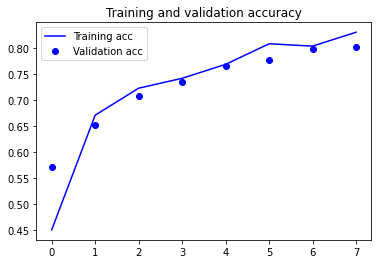

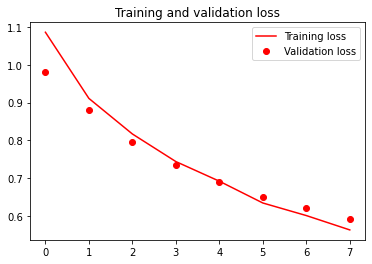

                      precision    recall  f1-score   support

diabetic retinopathy       0.76      0.87      0.81       231
            glaucoma       0.72      0.64      0.68       165
              normal       0.94      0.87      0.90       168

            accuracy                           0.80       564
           macro avg       0.81      0.79      0.80       564
        weighted avg       0.80      0.80      0.80       564



In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_inception_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
out_layer = base_inception_model.output
out_layer = GlobalAveragePooling2D()(out_layer)
# let's add a fully-connected layer
out_layer = Dense(1024, activation='relu')(out_layer)
# and a logistic layer of 3 classes
predictions = Dense(3, activation='softmax')(out_layer)
#predictions = Dense(3, activation='sigmoid')(out_layer)

# this is the model we will train
inception_model = Model(inputs=base_inception_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_inception_model.layers:
    layer.trainable = False

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in inception_model.layers[:249]:
   layer.trainable = False
for layer in inception_model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
optAdam = Adam(lr=1e-3)
optSDG = SGD(lr=0.0001, momentum=0.9)
inception_model.compile(optimizer=optSDG, loss='categorical_crossentropy',
              metrics=['accuracy'])
#'categorical_crossentropy'

print(len(inception_model.layers))
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
Inception_history = inception_model.fit(X_train, y_train, batch_size=32, epochs=8, validation_data=(X_test, y_test), verbose=1)

inception_model.summary()

Plot_History(Inception_history)

inception_predictions = inception_model.predict(X_test, batch_size=32)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(inception_predictions, axis=1), target_names=target_names))

Diabetic Retinopathy image ./Data/train/train/378e00035231.jpg Glaucoma image ./Data/train/train/fc7a12b08625.jpg


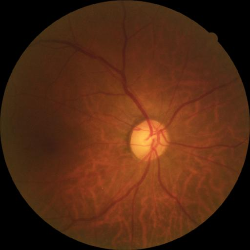

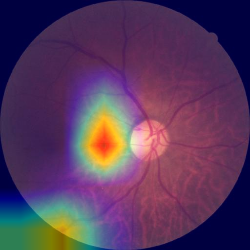

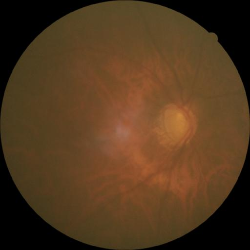

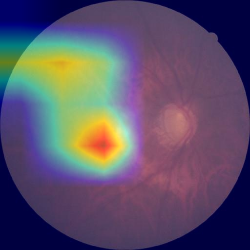

In [26]:
dr_image_idx_rand = np.random.randint(0, len(diag_retino_label)/2)
dr_image_path = PATH+input_csv_data.iloc[diag_retino_label[dr_image_idx_rand], 0]

g_image_idx_rand = np.random.randint(0, len(glaucoma_label)/2)
g_image_path = PATH+input_csv_data.iloc[glaucoma_label[g_image_idx_rand], 0]

print(f'Diabetic Retinopathy image {dr_image_path} Glaucoma image {g_image_path}')

gradCAM(dr_image_path, inception_model, 'conv2d_93')
gradCAM(g_image_path, inception_model, 'conv2d_93')

In [27]:
import glob
TEST_PATH="./Data/test/test"
images_unlabled_filenames = glob.glob(TEST_PATH + '/*.jpg')
print(len(images_unlabled_filenames))
print(images_unlabled_filenames[0])

350
./Data/test/test/0157f50bdb02.jpg


In [28]:
test_image = []
for i in tqdm(range(len(images_unlabled_filenames))):
    img = image.load_img(images_unlabled_filenames[i], target_size=(256,256,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
X_Test_Images = np.array(test_image)



100%|██████████| 350/350 [02:20<00:00,  2.49it/s]


In [29]:
one_hot_labels = np.zeros((X_Test_Images.shape[0], 3))
print(f'Input image size {X_Test_Images.shape[0]} and label size {one_hot_labels.shape[0]}')

Input image size 350 and label size 350


#Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.]

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```

In [33]:
X_unlabled_dense=list()
Y_unlabled_predict=list()
for i in range(np.shape(X_Test_Images)[0]):
    #print(i)
    img=X_Test_Images[i]
    img = np.expand_dims(img,axis=0)
    result = inception_model.predict(img)
    X_unlabled_dense.append(result)
    label=np.argmax(inception_model.predict(img))
    Y_unlabled_predict.append(label)
#print(len(X_unlabled_dense))
#print(Y_unlabled_predict)

350
[0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 2, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 0, 0, 1, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 2, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,

In [35]:
onehot_encoded_unlabled = list()
for value in Y:
	letter = [0 for _ in range(len(target_names))]
	letter[value] = 1
	onehot_encoded_unlabled.append(letter)
#print(onehot_encoded_unlabled)
encoded_unlabled = np.asarray(onehot_encoded_unlabled)

In [39]:
X_total_images = np.concatenate((X, X_Test_Images))
Labels_total_images = np.concatenate((data_labels, encoded_unlabled))
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X_total_images, Labels_total_images, random_state=42, test_size=0.3)

In [40]:
Inception_history_total = inception_model.fit(X_train_total, y_train_total, batch_size=32, epochs=8, verbose=1, validation_data=(X_test_total, y_test_total))

Epoch 1/8
49/49 [==============================] - 4s 90ms/step - loss: 0.5345 - accuracy: 0.8357 - val_loss: 0.5274 - val_accuracy: 0.8445
Epoch 2/8
49/49 [==============================] - 3s 66ms/step - loss: 0.5021 - accuracy: 0.8472 - val_loss: 0.5056 - val_accuracy: 0.8460
Epoch 3/8
49/49 [==============================] - 3s 66ms/step - loss: 0.4627 - accuracy: 0.8646 - val_loss: 0.4877 - val_accuracy: 0.8505
Epoch 4/8
49/49 [==============================] - 3s 66ms/step - loss: 0.4414 - accuracy: 0.8736 - val_loss: 0.4729 - val_accuracy: 0.8490
Epoch 5/8
49/49 [==============================] - 3s 66ms/step - loss: 0.4056 - accuracy: 0.8902 - val_loss: 0.4608 - val_accuracy: 0.8550
Epoch 6/8
49/49 [==============================] - 3s 66ms/step - loss: 0.3896 - accuracy: 0.8864 - val_loss: 0.4495 - val_accuracy: 0.8505
Epoch 7/8
49/49 [==============================] - 3s 66ms/step - loss: 0.3759 - accuracy: 0.8935 - val_loss: 0.4391 - val_accuracy: 0.8550
Epoch 8/8
49/49 [===

{'loss': [0.5344948768615723, 0.502119243144989, 0.4627372622489929, 0.44140127301216125, 0.4056365191936493, 0.38958635926246643, 0.37594372034072876, 0.3491443693637848], 'accuracy': [0.8356868028640747, 0.8472400307655334, 0.8645699620246887, 0.8735558390617371, 0.8902438879013062, 0.8863928318023682, 0.8934531211853027, 0.9075738191604614], 'val_loss': [0.527350664138794, 0.5056139826774597, 0.4877232611179352, 0.47291553020477295, 0.4607974886894226, 0.4495232105255127, 0.43913188576698303, 0.4306440055370331], 'val_accuracy': [0.8445441126823425, 0.8460388779640198, 0.8505231738090515, 0.8490284085273743, 0.8550074696540833, 0.8505231738090515, 0.8550074696540833, 0.8579970002174377]}


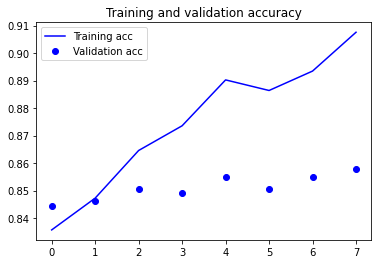

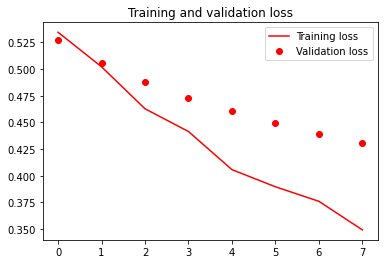

                      precision    recall  f1-score   support

diabetic retinopathy       0.82      0.91      0.86       231
            glaucoma       0.80      0.72      0.76       165
              normal       0.96      0.91      0.93       168

            accuracy                           0.85       564
           macro avg       0.86      0.85      0.85       564
        weighted avg       0.86      0.85      0.85       564



In [41]:
Plot_History(Inception_history_total)

inception_predictions = inception_model.predict(X_test, batch_size=32)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(inception_predictions, axis=1), target_names=target_names))

# For this assignment, you are working with specialists for Diabetic Retinopathy and Glaucoma only, and your client is interested in a predictive learning model along with feature explanability and self-learning for Diabetic Retinopathy and Glaucoma vs. Normal images.
# Design models and methods for the following tasks. Each task should be accompanied by code, plots/images (if applicable), tables (if applicable) and text:
## Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images. You may consider multi-class classification vs. all-vs-one classification. Clearly state your choice and share details of your model, paremeters and hyper-paramaterization pprocess. (60 points)
```
a. Perform 70/30 data split and report performance scores on the test data set.
b. You can choose to apply any data augmentation strategy. 
Explain your methods and rationale behind parameter selection.
c. Show Training-validation curves to ensure overfitting and underfitting is avoided.
```
## Task 2: Visualize the heatmap/saliency/features using any method of your choice to demonstrate what regions of interest contribute to Diabetic Retinopathy and Glaucoma, respectively. (25 points)
```
Submit images/folder of images with heatmaps/features aligned on top of the images, or corresponding bounding boxes, and report what regions of interest in your opinion represent the pathological sites.
```

## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.] 

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```

## [Hint: If you are wondering how to use the "dense layer representative of an image" in step 2, see this exercise that extracts a [1,2048] dense representattive from an image using the InceptionV3 pre-trained model.]
https://colab.research.google.com/drive/14-6qRGARgBSj4isZk86zKQtyIT2f9Wu1#scrollTo=_IqraxtP4Ex3


## Good Luck!

In [16]:
one_hot_labels = np.zeros((input_csv_data.shape[0], 3))
print(one_hot_labels.shape)
# Set column 0 'normal' to 1 in the rows where the label is 1
one_hot_labels[normal_label, 0] = 1
# Set column 1 'diabetic retinopathy' or 'glaucoma' to 1 in the rows where the label is 1
one_hot_labels[drg_label_tgr, 1] = 1
one_hot_labels[drg_label_ex, 1] = 1
# Set column 2 'others' to 1 in the rows where the label is not known
othr_labels = np.where((one_hot_labels[:,0] == 0) & (one_hot_labels[:,1] == 0))[0]
one_hot_labels[othr_labels, 2] = 1


#print(one_hot_labels[2875:2925, :])

(3435, 3)


In [ ]:
model = Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3),padding='same',input_shape=(3 , 100, 100)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))


# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# model.load_weights("weights.16-0.86800.hdf5")

check = ModelCheckpoint("weights.{epoch:02d}-{val_acc:.5f}.hdf5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
model.fit(x_train, y_train, batch_size=32, nb_epoch=20,callbacks=[check],validation_data=(x_test,y_test))

out = model.predict_proba(x_test)
out = np.array(out)

threshold = np.arange(0.1,0.9,0.1)

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append( matthews_corrcoef(y_test[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

print "best thresholds", best_threshold
y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

print("-"*40)
print("Matthews Correlation Coefficient")
print("Class wise accuracies")
print(accuracies)

print("other statistics\n")
total_correctly_predicted = len([i for i in range(len(y_test)) if (y_test[i]==y_pred[i]).sum() == 5])
print("Fully correct output")
print(total_correctly_predicted)
print(total_correctly_predicted/400.)


In [ ]:
print(normal_label.shape)
print(drg_label_tgr.shape)
print(drg_label_ex.shape)
print(diag_retino_label.shape)
print(glaucoma_label.shape)

In [11]:
from keras.preprocessing import image

train_image = []
for i in tqdm(range(input_csv_data.shape[0])):
    img = image.load_img(PATH+input_csv_data['filename'][i], target_size=(256,256,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 3435/3435 [23:00<00:00,  2.49it/s]


In [ ]:
import sklearn.metrics as sm

def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
	See example code for helper function definitions
    """
    tn, fp, fn, tp = sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp

def get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list):
    """returns precision, recall, IoU and accuracy metrics
	"""
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    IoU=tp/(tp+fp+fn)
    
    return prec,rec,IoU,accuracy

def get_f1_score(groundtruth_list, predicted_list):
    """Return f1 score covering edge cases"""

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

def get_validation_metrics(groundtruth,predicted):
    """Return all output metrics. Input is binary images"""
   
    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    prec,rec,IoU,acc=get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list)
    f1_score=get_f1_score(groundtruth_list, predicted_list)
   # print("Precision=",prec, "Recall=",rec, "IoU=",IoU, "acc=",acc, "F1=",f1_score)
    return prec,rec,IoU,acc,f1_score

def evalResult(gth_path,npyfile,target_size=(256,256),flag_multi_class = False,num_class = 2):
    files=sorted(os.listdir(gth_path))
    #print(files)
    prec=0
    rec=0
    acc=0
    IoU=0
    f1_score=0
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        gth = io.imread(os.path.join(gth_path,files[i]))
        gth = trans.resize(gth,target_size)
        img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
        gth1=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
        p,r,I,a,f=get_validation_metrics(gth1,img1)
        prec=prec+p
        rec=rec+r
        acc=acc+a
        IoU=IoU+I
        f1_score=f1_score+f
    print("Precision=",prec/(i+1), "Recall=",rec/(i+1), "IoU=",IoU/(i+1), "acc=",acc/(i+1), "F1=",f1_score/(i+1))    

Model: "alex_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1796 (Conv2D)         (None, 123, 123, 96)      34944     
_________________________________________________________________
batch_normalization_1869 (Ba (None, 123, 123, 96)      384       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 61, 61, 96)        0         
_________________________________________________________________
conv2d_1797 (Conv2D)         (None, 61, 61, 256)       614656    
_________________________________________________________________
batch_normalization_1870 (Ba (None, 61, 61, 256)       1024      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_1798 (Conv2D)         (None, 30, 30, 384)       8

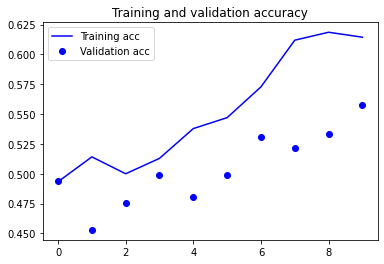

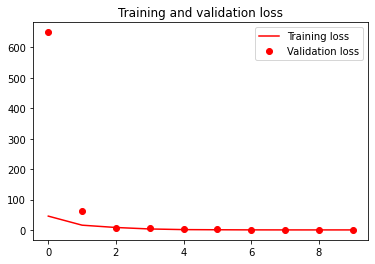

                                   precision    recall  f1-score   support

                           normal       0.72      0.88      0.79       155
diabetic retinopathy and glaucoma       0.49      0.78      0.60       404
                           others       0.64      0.26      0.37       472

                         accuracy                           0.56      1031
                        macro avg       0.62      0.64      0.59      1031
                     weighted avg       0.59      0.56      0.52      1031



In [82]:
# Define the AlexNet model [This is given]
#1. Model Definition
class AlexNet(Sequential):
   def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(32, kernel_size=(3,3), strides= 2,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    
    self.add(Conv2D(64, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    ))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 
    

    self.add(Conv2D(128, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    ))
    self.add(BatchNormalization())
    
    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    ))
    self.add(BatchNormalization())
    
    self.add(Conv2D(512, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    ))
    self.add(BatchNormalization())
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    

    self.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    self.add(Dense(num_classes, activation= 'softmax'))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #tf.keras.optimizers.Adam(learning_rate=0.01)
    
    self.compile(optimizer= sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    

alexnet_model = AlexNet((256, 256, 3),3)
alexnet_model.summary()
#alexnet_model.fit(train_images, batch_size=32, epochs = 10, verbose=1)
Alexnet_history = alexnet_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=1)
Plot_History(Alexnet_history)
alexnet_predict = alexnet_model.predict(X_test, batch_size=32)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(alexnet_predict, axis=1), target_names=target_names))

Diabetic Retinopathy image ./Data/train/train/f9dcdc3069cf.jpg Glaucoma image ./Data/train/train/2ce3692b67f0.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


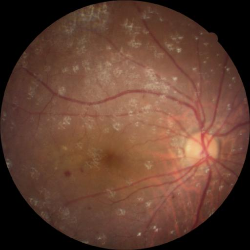

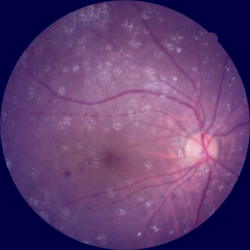

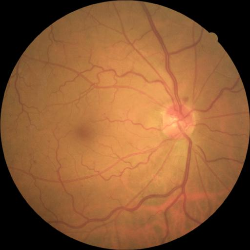

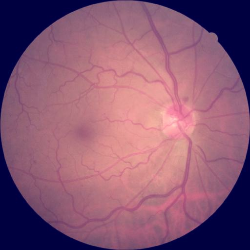

In [163]:
dr_image_idx = input_csv_data.index[(input_csv_data['diabetic retinopathy'] == 1)].to_numpy()
dr_image_idx_rand = np.random.randint(0, len(dr_image_idx)/2)
dr_image_path = PATH+input_csv_data.iloc[dr_image_idx[dr_image_idx_rand], 0]

g_image_idx = input_csv_data.index[(input_csv_data['glaucoma'] == 1)].to_numpy()
g_image_idx_rand = np.random.randint(0, len(g_image_idx)/2)
g_image_path = PATH+input_csv_data.iloc[g_image_idx[g_image_idx_rand], 0]

print(f'Diabetic Retinopathy image {dr_image_path} Glaucoma image {g_image_path}')

gradCAM(dr_image_path, alexnet_model, 'conv2d_1800', 30)
gradCAM(g_image_path, alexnet_model, 'conv2d_1800', 30)

175
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_99 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_99[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

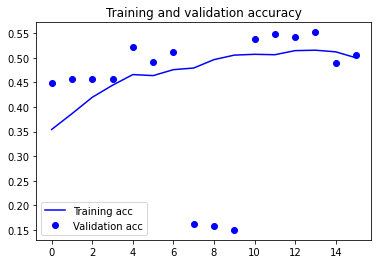

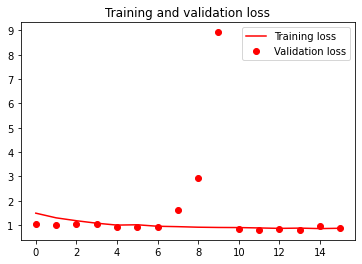

                                   precision    recall  f1-score   support

                           normal       0.91      0.34      0.49       155
diabetic retinopathy and glaucoma       0.00      0.00      0.00       404
                           others       0.48      1.00      0.65       472

                         accuracy                           0.51      1031
                        macro avg       0.46      0.44      0.38      1031
                     weighted avg       0.36      0.51      0.37      1031



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
from tensorflow.keras.layers import AveragePooling2D

input_size = keras.Input(shape=(256, 256, 3))
pretained_model = keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=input_size)
print(len(pretained_model.layers))
for layer in pretained_model.layers[:150]:
    layer.trainable = False

resnet_model = keras.models.Sequential()
resnet_model.add(tf.keras.Input(shape=(256, 256, 3)))
resnet_model.add(pretained_model)
resnet_model.add(keras.layers.AveragePooling2D(pool_size=(8,8)))
resnet_model.add(keras.layers.Flatten())
resnet_model.add(keras.layers.BatchNormalization())
resnet_model.add(keras.layers.Dense(1024, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(keras.layers.BatchNormalization())
resnet_model.add(keras.layers.Dense(512, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))

resnet_model.add(keras.layers.BatchNormalization())
resnet_model.add(keras.layers.Dense(256, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(keras.layers.BatchNormalization())
resnet_model.add(keras.layers.Dense(128, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(keras.layers.BatchNormalization())

resnet_model.add(keras.layers.Dense(64, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(keras.layers.BatchNormalization())
resnet_model.add(keras.layers.Dense(3, activation='softmax'))

optAdam = Adam(lr=1e-3)
optSGD = SGD(lr=1e-4, momentum=0.9)

resnet_model.compile(loss='categorical_crossentropy',
              optimizer=optAdam,
              metrics=['accuracy'])
pretained_model.summary()

Resnet_history = resnet_model.fit(X_train, y_train, batch_size=32, epochs=16, verbose=1, validation_data=(X_test, y_test))
resnet_model.summary()
resnet_predict = resnet_model.predict(X_test, batch_size=32)
Plot_History(Resnet_history)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(resnet_predict, axis=1), target_names=target_names))